In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns


In [ ]:
class CollaborativeFiltering:
    def __init__(self, n_factors=10, learning_rate=0.005, regularization=0.01):
        self.n_factors = n_factors
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        
    def _clip_rating(self, rating):
        return np.clip(rating, 1, 5)
    
    def fit(self, train_data, n_epochs=20, batch_size=1000, verbose=True):
        train_data = train_data.copy()
        train_data = train_data.dropna(subset=['rating'])
        train_data['rating'] = self.scaler.fit_transform(train_data[['rating']])
        
        self.user_mapping = {id_: i for i, id_ in enumerate(train_data['user_id'].unique())}
        self.anime_mapping = {id_: i for i, id_ in enumerate(train_data['anime_id'].unique())}
        
        n_users = len(self.user_mapping)
        n_items = len(self.anime_mapping)
        
        self.user_factors = np.random.normal(0, 0.01, (n_users, self.n_factors))
        self.item_factors = np.random.normal(0, 0.01, (n_items, self.n_factors))
        
        train_data['user_idx'] = train_data['user_id'].map(self.user_mapping)
        train_data['anime_idx'] = train_data['anime_id'].map(self.anime_mapping)
        
        best_loss = float('inf')
        patience = 5
        patience_counter = 0
        
        for epoch in range(n_epochs):
            train_data = train_data.sample(frac=1).reset_index(drop=True)
            total_loss = 0
            batch_count = 0
            
            for start_idx in range(0, len(train_data), batch_size):
                batch = train_data.iloc[start_idx:start_idx + batch_size]
                
                user_ids = batch['user_idx'].values
                item_ids = batch['anime_idx'].values
                ratings = batch['rating'].values
                
                predictions = np.sum(
                    self.user_factors[user_ids] * self.item_factors[item_ids], 
                    axis=1
                )
                
                errors = ratings - predictions
                
                for i in range(len(batch)):
                    user_id = user_ids[i]
                    item_id = item_ids[i]
                    error = errors[i]
                    
                    user_vec = self.user_factors[user_id].copy()
                    item_vec = self.item_factors[item_id].copy()
                    
                    self.user_factors[user_id] += self.learning_rate * (error * item_vec - self.regularization * user_vec)
                    self.item_factors[item_id] += self.learning_rate * (error * user_vec - self.regularization * item_vec)
                
                batch_loss = np.mean(np.square(errors))
                if not np.isnan(batch_loss):
                    total_loss += batch_loss
                    batch_count += 1
            
            if batch_count > 0:
                avg_loss = total_loss / batch_count
                
                if avg_loss < best_loss:
                    best_loss = avg_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                if patience_counter >= patience:
                    if verbose:
                        print(f'Early stopping at epoch {epoch + 1}')
                    break
                
                if verbose and (epoch + 1) % 5 == 0:
                    print(f'Epoch {epoch + 1}/{n_epochs} - Loss: {avg_loss:.4f}')
    
    def predict(self, user_id, anime_id):
        if user_id not in self.user_mapping or anime_id not in self.anime_mapping:
            return None
            
        user_idx = self.user_mapping[user_id]
        anime_idx = self.anime_mapping[anime_id]
        
        pred = np.dot(self.user_factors[user_idx], 
                     self.item_factors[anime_idx])
        
        pred = self.scaler.inverse_transform([[pred]])[0][0]
        
        return self._clip_rating(pred)
    
    
    def calculate_final_metrics(self, test_data):
        test_data = test_data.copy()
        test_data = test_data.dropna(subset=['rating'])
        valid_users = test_data['user_id'].isin(self.user_mapping.keys())
        valid_animes = test_data['anime_id'].isin(self.anime_mapping.keys())
        test_data = test_data[valid_users & valid_animes].copy()
        
        if len(test_data) == 0:
            print("No valid data for testing after filtering")
            return None
            
        test_data['user_idx'] = test_data['user_id'].map(self.user_mapping)
        test_data['anime_idx'] = test_data['anime_id'].map(self.anime_mapping)
        
        original_ratings = test_data['rating'].values
        
        predictions = np.sum(
            self.user_factors[test_data['user_idx'].astype(int).values] * 
            self.item_factors[test_data['anime_idx'].astype(int).values],
            axis=1
        )
        
        predictions = self.scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
        predictions = np.clip(predictions, 1, 5)
        
        mse = np.mean((original_ratings - predictions) ** 2)
        rmse = np.sqrt(mse)
        mae = np.mean(np.abs(original_ratings - predictions))
        accuracy = np.mean(np.abs(predictions - original_ratings) <= 0.5)
        
        self.final_metrics = {
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'Accuracy': accuracy,
            'n_samples': len(test_data),
            'predictions': predictions,
            'actual_ratings': original_ratings
        }
        
        print("\nFinal Evaluation Metrics:")
        print(f"Number of test samples: {len(test_data)}")
        print(f"MSE: {mse:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"MAE: {mae:.4f}")
        print(f"Accuracy (±0.5): {accuracy * 100:.4f}%")
        
        return self.final_metrics


In [ ]:
df = pd.read_csv('cleaned_datasets/user_scores_cleaned.csv')
data = df.sample(frac = 0.16, random_state=40)

train_data, test_data = train_test_split(data, test_size = 0.3, random_state = 40)

model = CollaborativeFiltering(
    n_factors=20,
    learning_rate=0.01,
    regularization=0.01
)

model.fit(train_data, n_epochs=25, batch_size=700)
metrics = model.calculate_final_metrics(test_data)
predictions = metrics['predictions']
actual_ratings = metrics['actual_ratings']



Epoch 5/25 - Loss: 0.5756
Epoch 10/25 - Loss: 0.3264
Epoch 15/25 - Loss: 0.0911
Epoch 20/25 - Loss: 0.0539
Epoch 25/25 - Loss: 0.0408

Final Evaluation Metrics:
Number of test samples: 249190
MSE: 10.5453
RMSE: 3.2473
MAE: 2.9075
Accuracy (±0.5): 4.9111%


/Users/seokwoopark/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


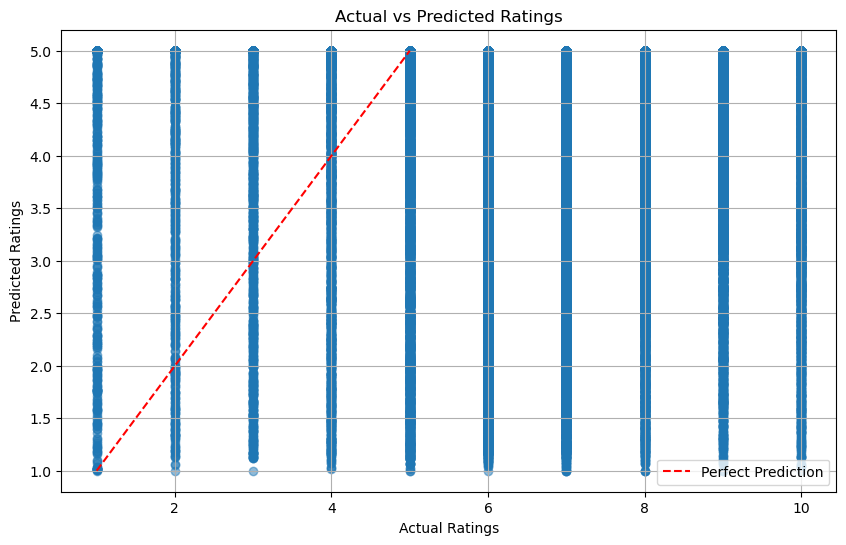

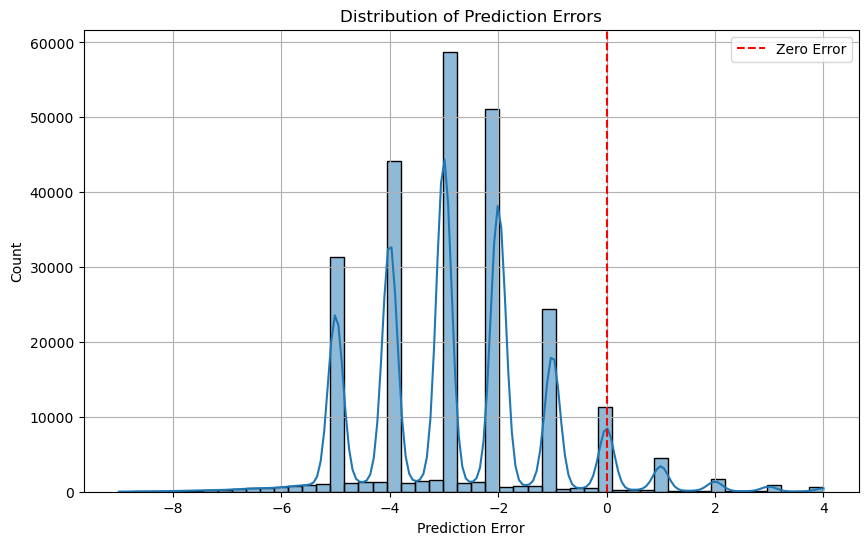

Mean Error: -2.7889
Error Std: 1.6635


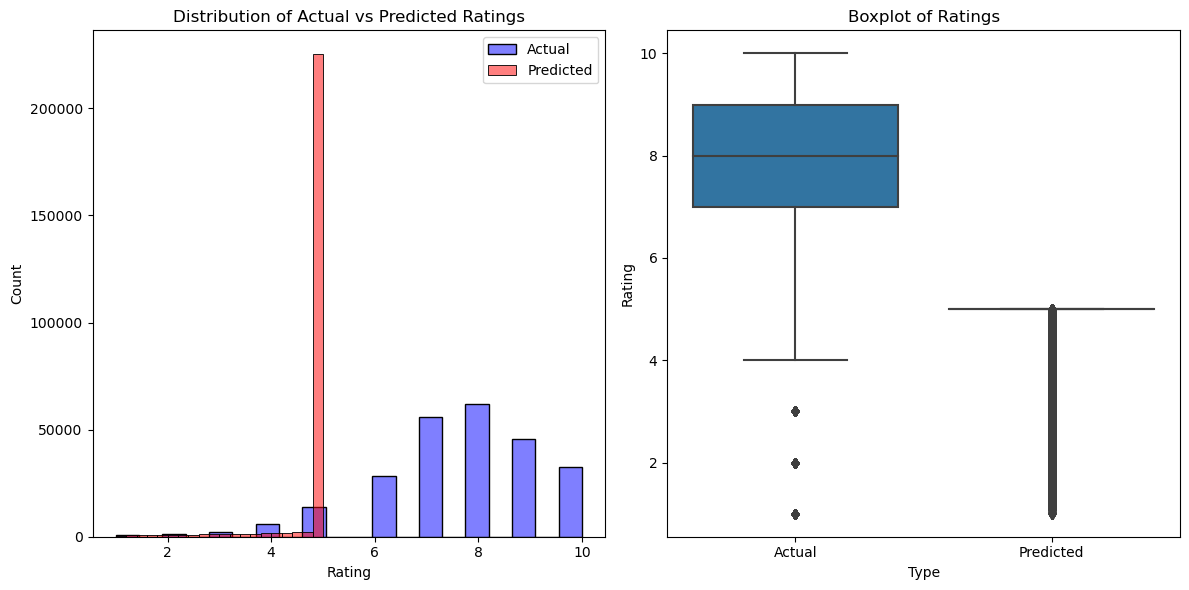

Actual Ratings - Mean: 7.6255, Std: 1.6547
Predicted Ratings - Mean: 4.8366, Std: 0.5923


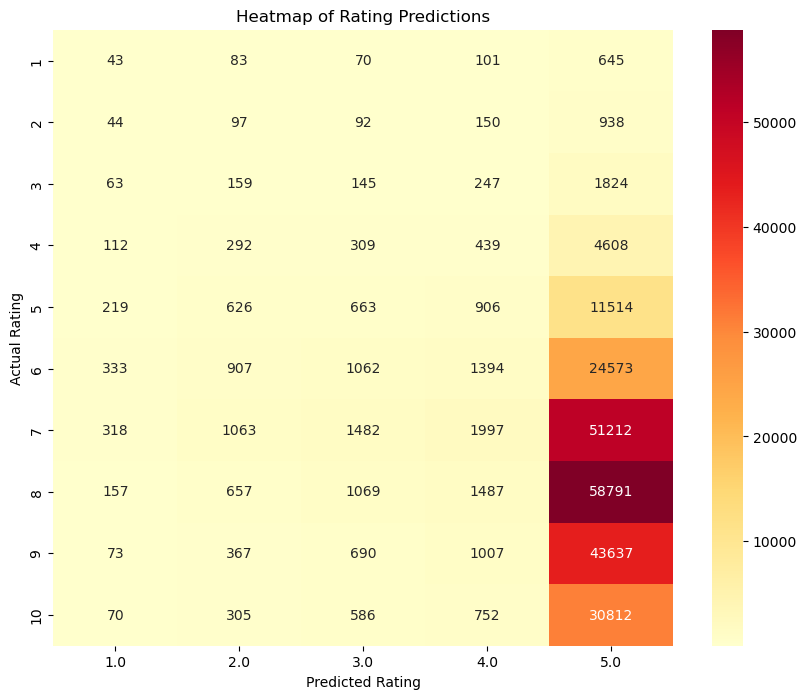

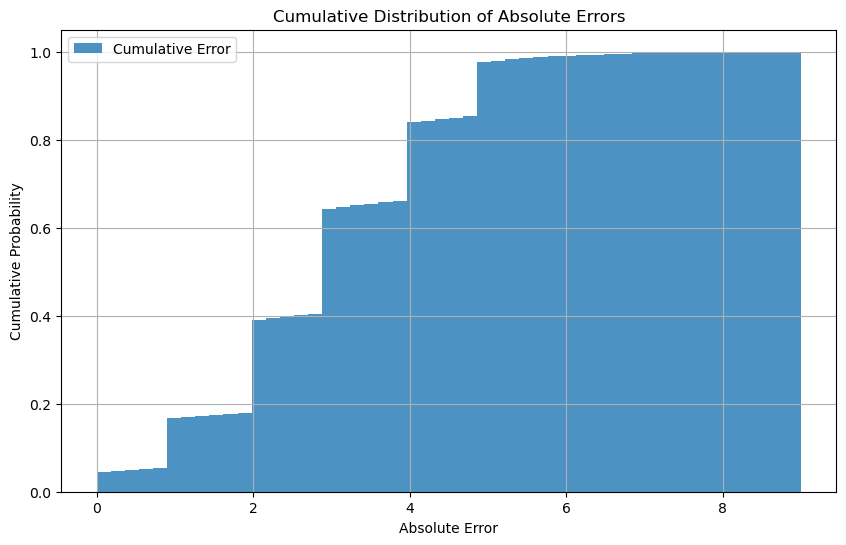

Predictions within 0.5 error: 4.91%
Predictions within 1.0 error: 16.58%
Predictions within 1.5 error: 17.36%


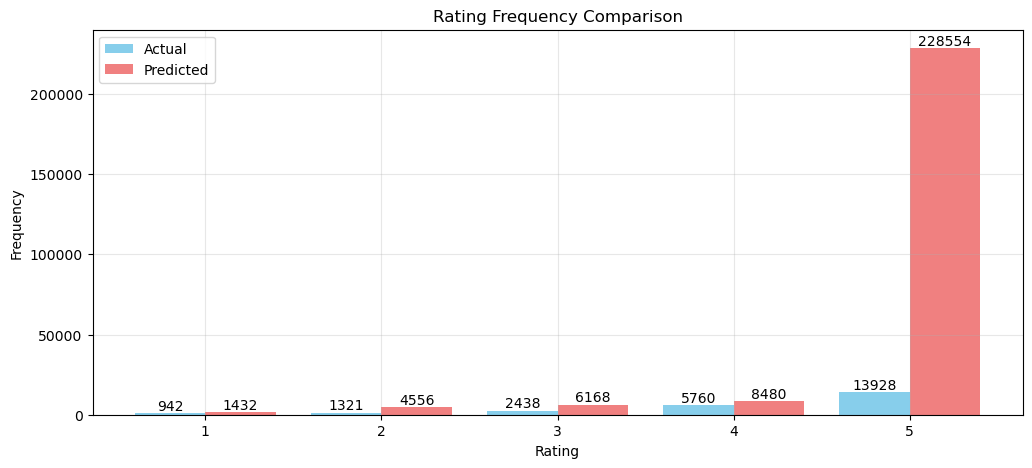


Rating Distribution Summary:

Actual Ratings:
1      942
2     1321
3     2438
4     5760
5    13928
dtype: int64

Predicted Ratings:
1      1432
2      4556
3      6168
4      8480
5    228554
dtype: int64


In [ ]:
def plot_prediction_scatter(actual, predicted):
    plt.figure(figsize=(10, 6))
    plt.scatter(actual, predicted, alpha=0.5)
    plt.plot([1, 5], [1, 5], 'r--', label='Perfect Prediction')
    plt.xlabel('Actual Ratings')
    plt.ylabel('Predicted Ratings')
    plt.title('Actual vs Predicted Ratings')
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_error_distribution(actual, predicted):
    errors = predicted - actual
    
    plt.figure(figsize=(10, 6))
    sns.histplot(errors, bins=50, kde=True)
    plt.xlabel('Prediction Error')
    plt.ylabel('Count')
    plt.title('Distribution of Prediction Errors')
    plt.axvline(x=0, color='r', linestyle='--', label='Zero Error')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    print(f"Mean Error: {np.mean(errors):.4f}")
    print(f"Error Std: {np.std(errors):.4f}")

def plot_rating_distributions(actual, predicted):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(actual, bins=20, color='blue', alpha=0.5, label='Actual')
    sns.histplot(predicted, bins=20, color='red', alpha=0.5, label='Predicted')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.title('Distribution of Actual vs Predicted Ratings')
    plt.legend()
    plt.subplot(1, 2, 2)
    
    df = pd.DataFrame({
        'Rating': np.concatenate([actual, predicted]),
        'Type': ['Actual']*len(actual) + ['Predicted']*len(predicted)
    })

    sns.boxplot(data=df, x='Type', y='Rating')
    plt.ylabel('Rating')
    plt.title('Boxplot of Ratings')

    plt.tight_layout()
    plt.show()
    
    print(f"Actual Ratings - Mean: {np.mean(actual):.4f}, Std: {np.std(actual):.4f}")
    print(f"Predicted Ratings - Mean: {np.mean(predicted):.4f}, Std: {np.std(predicted):.4f}")

def plot_prediction_heatmap(actual, predicted):
    error_matrix = pd.DataFrame({
        'Actual': actual,
        'Predicted': np.round(predicted)
    })

    error_counts = pd.crosstab(error_matrix['Actual'], error_matrix['Predicted'])

    plt.figure(figsize=(10, 8))
    sns.heatmap(error_counts, annot=True, fmt='d', cmap='YlOrRd')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Actual Rating')
    plt.title('Heatmap of Rating Predictions')
    plt.show()

def plot_cumulative_error(actual, predicted):
    errors = np.abs(predicted - actual)

    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=50, density=True, cumulative=True, 
             alpha=0.8, label='Cumulative Error')
    plt.xlabel('Absolute Error')
    plt.ylabel('Cumulative Probability')
    plt.title('Cumulative Distribution of Absolute Errors')
    plt.grid(True)
    plt.legend()
    plt.show()
    
    for threshold in [0.5, 1.0, 1.5]:
        ratio = np.mean(errors <= threshold) * 100
        print(f"Predictions within {threshold} error: {ratio:.2f}%")

def plot_error_reliability(actual, predicted):
    errors = np.abs(predicted - actual)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(predicted, errors, alpha=0.5)
    plt.xlabel('Predicted Rating')
    plt.ylabel('Absolute Error')
    plt.title('Prediction Error vs Predicted Rating')
    plt.grid(True)
    
    bins = np.linspace(min(predicted), max(predicted), 10)
    bin_means = []
    bin_centers = []
    
    for i in range(len(bins)-1):
        mask = (predicted >= bins[i]) & (predicted < bins[i+1])
        if np.sum(mask) > 0:
            bin_means.append(np.mean(errors[mask]))
            bin_centers.append((bins[i] + bins[i+1])/2)
    
    plt.plot(bin_centers, bin_means, 'r-', linewidth=2, label='Mean Error')
    plt.legend()
    plt.show()

def plot_rating_frequency(actual, predicted):
    plt.figure(figsize=(12, 5))
    actual_counts = pd.Series(actual).value_counts().sort_index()
    pred_counts = pd.Series(np.round(predicted)).value_counts().sort_index()
    all_ratings = np.arange(1, 6)
    actual_counts = actual_counts.reindex(all_ratings, fill_value=0)
    pred_counts = pred_counts.reindex(all_ratings, fill_value=0)
    
    plt.bar(all_ratings - 0.2, actual_counts, width=0.4, label='Actual', color='skyblue', align='center')
    plt.bar(all_ratings + 0.2, pred_counts, width=0.4, label='Predicted', color='lightcoral', align='center')
    plt.xlabel('Rating')
    plt.ylabel('Frequency')
    plt.title('Rating Frequency Comparison')
    plt.legend()
    plt.xticks(all_ratings)
    plt.grid(True, alpha=0.3)
    
    for i, v in zip(all_ratings, actual_counts):
        plt.text(i - 0.2, v, str(int(v)), ha='center', va='bottom')
    for i, v in zip(all_ratings, pred_counts):
        plt.text(i + 0.2, v, str(int(v)), ha='center', va='bottom')
    
    plt.show()
    
    print("\nRating Distribution Summary:")
    print("\nActual Ratings:")
    print(actual_counts)
    print("\nPredicted Ratings:")
    print(pred_counts)

def analyze_predictions(actual, predicted):
    plot_prediction_scatter(actual, predicted)
    plot_error_distribution(actual, predicted)
    plot_rating_distributions(actual, predicted)
    plot_prediction_heatmap(actual, predicted)
    plot_cumulative_error(actual, predicted)
    plot_rating_frequency(actual_ratings, predictions)

analyze_predictions(actual_ratings, predictions)

EDA Part
- Hypothesis: By training Collaborative Filtering on specific anime ratings, I can predict how users with similar tastes would rate them.
- Algorithm: Collaborative Filtering
- Resource(Cite): https://en.wikipedia.org/wiki/Collaborative_filtering

# ------------------------------------------------
Justification for why chose Collaborative Filtering

The data structure is ideal for Collaborative Filtering as it contains the essential user-item-rating matrix components through user_id, anime_id, and rating columns.
The rating system provides explicit feedback on a standardized 1-5 scale and make it reasonable for understanding user preferences quantitatively. This numerical representation of user preferences is crucial for Collaborative Filtering algorithms to identify patterns.
The cross-interaction pattern in the data, where users rate multiple anime and each anime receives ratings from multiple users, creates a rich network of preferences. This interconnected rating pattern enables the algorithm to identify similarities between users and items effectively.

# ------------------------------------------------
Tune/train the model

The training process is defined to run for a maximum of 25 epochs with a batch size of 700 samples. This batch size selection provides an effective balance between computational efficiency and gradient update stability. An early stopping mechanism with a patience of 5 epochs is implemented to prevent unnecessary training iterations when the model stops improving.
The model's performance is evaluated using a comprehensive set of metrics. These include Mean Squared Error (MSE) for overall prediction error, Root Mean Squared Error (RMSE) for interpretable error in the original rating scale, Mean Absolute Error (MAE) for average prediction deviation, and an accuracy measure based on predictions within ±0.5 of the actual rating.
For training efficiency, the implementation uses 16% of the total dataset with a 70-30 train-test split, and maintains reproducibility through fixed random states. This approach allows faster iteration during development while still providing meaningful results.

# ------------------------------------------------
The effectiveness of the algorithm

The model's performance shows a clear pattern of decreasing loss during training, starting from 0.5756 and ending at 0.0408, which indicates the model is learning. However, the final evaluation metrics suggest several potential issues with the prediction quality. The high MSE of 10.5453 and RMSE of 3.2473 indicate significant deviation between predicted and actual ratings. This is particularly concerning given that the rating scale is only 1-5 and meaning the average prediction error is more than half the entire rating range. The relatively low accuracy of 4.9111% (predictions within ±0.5 of actual ratings) suggests that the model is struggling to make precise predictions. The large test sample size of 249,190 ratings suggests high data sparsity, which is a common challenge in recommendation systems. Many users might have rated only a few anime, making it difficult to establish reliable preference patterns.

# ------------------------------------------------
Insights gained from the algorithm

While I developed a traditional approach to recommendation systems, the accuracy was unsatisfactory. I learned that building a recommendation engine involves considerable resources and multiple variable components.
